In [4]:
from torch.utils.data import DataLoader, random_split
from torch import optim
from tqdm.notebook import tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, datasets
import matplotlib.pyplot as plt

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Dataset

We will be using MNIST dataset which consists of 60000 data. We split them into train and validation sets, each having 50000 and 10000 data respectively.

In [6]:
transformation = transforms.Compose([
        transforms.ToTensor(),
    ])

In [7]:
mnist_data = datasets.MNIST(root='data/', download=True, transform=transformation)

train_data, valid_data = random_split(mnist_data, [50000, 10000])

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:16<00:00, 595471.20it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 131134.86it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 244038.07it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 10525154.02it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [8]:
train_loader = DataLoader(train_data, batch_size=128, shuffle=True, num_workers=2)

# VAE

Variational Autoencoders (VAEs) are a class of generative models that aim to learn the probability distribution of a given dataset in order to generate new data points that resemble the original data. They use and encoder that embeds each data to a smaller latent space and a decoder that tries to generate the original image, given this latent space.

![](https://upload.wikimedia.org/wikipedia/commons/thumb/4/4a/VAE_Basic.png/425px-VAE_Basic.png)
---


In [9]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2_mean = nn.Linear(hidden_dim, latent_dim)
        self.fc2_log_var = nn.Linear(hidden_dim, latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):

        h = self.relu(self.fc1(x))
        z_mean = self.fc2_mean(h)
        z_log_var = self.fc2_log_var(h)

        return z_mean, z_log_var

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()

        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, z):

        h = self.relu(self.fc1(z))
        x = self.sigmoid(self.fc2(h))  # Use sigmoid for MNIST, as the pixel values are in [0,1]

        return x

In [14]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(VAE, self).__init__()

        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim)

    def reparameterize(self, z_mean, z_log_var):
        # Reparameterization trick: z = mu + sigma * epsilon
        std = torch.exp(0.5 * z_log_var)
        eps = torch.randn_like(std)
        return z_mean + eps * std

    def forward(self, x):
        # Encode the input to the latent space
        z_mean, z_log_var = self.encoder(x)

        # Reparameterize to get the latent vector
        z = self.reparameterize(z_mean, z_log_var)

        # Decode the latent vector to reconstruct the image
        image = self.decoder(z)

        return image, z_mean, z_log_var


In [11]:
def reconstruct_images(vae, images):
    with torch.no_grad():
        recon_images, _, _ = vae(images)
    return recon_images

In [18]:
def train_vae(dataloader, latent_dim, hidden_dim, input_dim, learning_rate=1e-4, num_epochs=100):
    # Define the VAE model
    model = VAE(input_dim=input_dim, hidden_dim=hidden_dim, latent_dim=latent_dim).to(DEVICE)

    # Define the optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Define the loss function
    # Reconstruction loss (MSE) + KL divergence
    def loss_function(recon_x, x, mu, logvar):
        # Mean Squared Error (MSE) for reconstruction
        MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
        # KL Divergence: 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
        KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return MSE + KLD

    sample_images, _ = next(iter(dataloader))
    sample_images = sample_images.view(-1, input_dim).to(DEVICE)

    recon_images = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        with tqdm(enumerate(dataloader), total=len(dataloader)) as pbar:
            for i, data in pbar:
                images, _ = data
                images = images.to(DEVICE)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass through the VAE
                recon_images, mu, logvar = model(images.view(-1, input_dim))

                # Calculate the loss
                loss = loss_function(recon_images, images.view(-1, input_dim), mu, logvar)

                # Backward pass and optimization
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                pbar.set_postfix(loss=loss.item() / len(images))

            print('Epoch [{}/{}] Loss: {:.4f}'.format(epoch+1, num_epochs, train_loss / len(dataloader.dataset)))

    return model


In [ ]:
latent_dim = 20          # Dimensionality of the latent space
hidden_dim = 400         # Number of neurons in the hidden layers
input_dim = 28 * 28      # Dimensionality of the input (MNIST images are 28x28 pixels)

model = train_vae(train_loader, latent_dim, hidden_dim, input_dim)

  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [1/100] Loss: 76.9969


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [2/100] Loss: 51.4737


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [3/100] Loss: 45.5601


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [4/100] Loss: 42.6476


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [5/100] Loss: 40.7189


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [6/100] Loss: 39.1731


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [7/100] Loss: 37.9440


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [8/100] Loss: 37.0556


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [9/100] Loss: 36.3229


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [10/100] Loss: 35.7921


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [11/100] Loss: 35.2762


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [12/100] Loss: 34.8772


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [13/100] Loss: 34.5411


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [14/100] Loss: 34.2663


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [15/100] Loss: 33.9660


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [16/100] Loss: 33.7127


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [17/100] Loss: 33.5264


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [18/100] Loss: 33.3244


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [19/100] Loss: 33.1297


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [20/100] Loss: 32.9652


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [21/100] Loss: 32.8296


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [22/100] Loss: 32.6734


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [23/100] Loss: 32.5697


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [24/100] Loss: 32.4360


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [25/100] Loss: 32.3317


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [26/100] Loss: 32.2461


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [27/100] Loss: 32.1357


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [28/100] Loss: 32.0379


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [29/100] Loss: 31.9689


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [30/100] Loss: 31.8709


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [31/100] Loss: 31.7918


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [32/100] Loss: 31.7211


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [33/100] Loss: 31.6570


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [34/100] Loss: 31.5793


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [35/100] Loss: 31.5418


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [36/100] Loss: 31.4758


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [37/100] Loss: 31.3907


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [38/100] Loss: 31.3566


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [39/100] Loss: 31.2991


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [40/100] Loss: 31.2970


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [41/100] Loss: 31.2503


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [42/100] Loss: 31.1611


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [43/100] Loss: 31.1317


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [44/100] Loss: 31.0711


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [45/100] Loss: 31.0312


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [46/100] Loss: 30.9942


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [47/100] Loss: 30.9491


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [48/100] Loss: 30.9550


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [49/100] Loss: 30.9244


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [50/100] Loss: 30.8794


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [51/100] Loss: 30.8328


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [52/100] Loss: 30.8110


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [53/100] Loss: 30.7766


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [54/100] Loss: 30.7544


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [55/100] Loss: 30.7311


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [56/100] Loss: 30.7060


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [57/100] Loss: 30.6693


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [58/100] Loss: 30.6589


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [59/100] Loss: 30.6108


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [60/100] Loss: 30.6057


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [61/100] Loss: 30.5792


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [62/100] Loss: 30.5756


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [63/100] Loss: 30.5484


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [64/100] Loss: 30.5312


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [65/100] Loss: 30.4946


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [66/100] Loss: 30.4596


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [67/100] Loss: 30.4411


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [68/100] Loss: 30.4449


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [69/100] Loss: 30.4068


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [70/100] Loss: 30.3846


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [71/100] Loss: 30.3889


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [72/100] Loss: 30.3690


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [73/100] Loss: 30.3138


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [74/100] Loss: 30.3131


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [75/100] Loss: 30.3301


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [76/100] Loss: 30.2922


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [77/100] Loss: 30.2808


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [78/100] Loss: 30.2591


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [79/100] Loss: 30.2470


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [80/100] Loss: 30.2330


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [81/100] Loss: 30.2271


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [82/100] Loss: 30.1969


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [83/100] Loss: 30.1711


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [84/100] Loss: 30.1646


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [85/100] Loss: 30.1556


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [86/100] Loss: 30.1707


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [87/100] Loss: 30.1455


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [88/100] Loss: 30.1024


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [89/100] Loss: 30.0863


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [90/100] Loss: 30.0726


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [91/100] Loss: 30.0787


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [92/100] Loss: 30.0680


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [93/100] Loss: 30.0615


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [94/100] Loss: 30.0451


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [95/100] Loss: 30.0431


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [96/100] Loss: 30.0244


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [97/100] Loss: 30.0057


  0%|          | 0/391 [00:00<?, ?it/s]

Epoch [98/100] Loss: 30.0098


  0%|          | 0/391 [00:00<?, ?it/s]

In [20]:
import torch
import matplotlib.pyplot as plt

def generate_and_plot_images(decoder, num_images=16, latent_dim=20):
    # Set the decoder to evaluation mode
    decoder.eval()

    # Sample from the standard normal distribution
    z = torch.randn(num_images, latent_dim).to(DEVICE)

    with torch.no_grad():
        # Generate images from the latent space samples
        generated_images = decoder(z)

    # Reshape the generated images to (num_images, channels, height, width)
    generated_images = generated_images.view(-1, 1, 28, 28)

    # Plot the generated images
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 2, 2))
    for i in range(num_images):
        axes[i].imshow(generated_images[i].cpu().numpy().squeeze(), cmap='gray')
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()


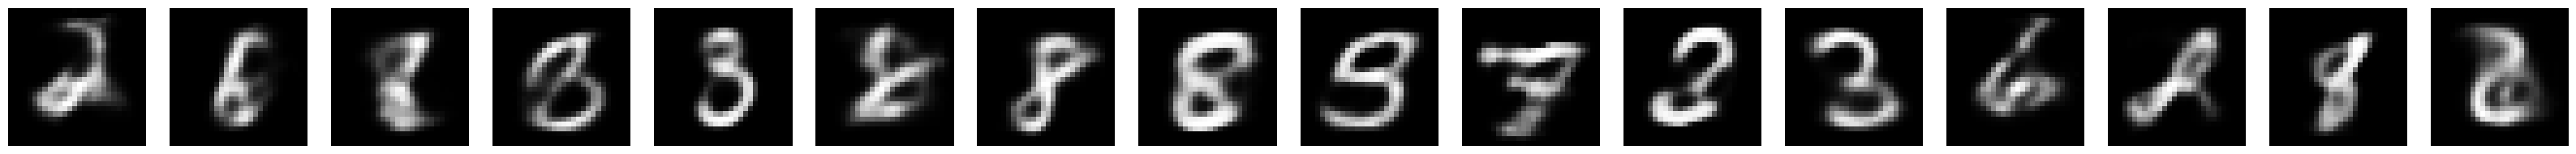

In [21]:
# Assuming you have a trained VAE model and the latent dimension is known
num_images = 16  # Number of images to generate
latent_dim = 20  # Latent dimension used during training

# Generate and plot images
generate_and_plot_images(model.decoder, num_images=num_images, latent_dim=latent_dim)